In [26]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.pyplot as plt
from ipywidgets import interact


In this notebook, we solve a storage flow relationship, assuming the so-called Muskingum equation. An important law we use (as always) is the continuity equation (i.e. how much flow goes into and out of a given river section, how much does this change the storage?)

$$
\frac{\partial{A}}{\partial{t}} + \frac{\partial{Q}}{\partial{x}} = 0
$$

Here $A$ [L$^2$] is the wetted cross-section, $t$ is the time [T], $Q$ [L$^3$ T$^{-1}$] is the flow and $x$ is the longitudinal position [L], usually we use meters and seconds for the magnitudes L and T.

We can integrate this equation over a certain length $x$ and simply look at the storage over a given channel section $S$, assuming that at any moment in time $S=Ax$, yielding:

$$
\frac{\Delta A\ x}{\Delta{t}} + \Delta{Q} = 0
$$
or in simpler terms:
$$
\frac{\Delta S}{\Delta t} = -\Delta Q
$$
When integrating over a certain time span $t_1$ until $t_2$ we yield:
$$
\frac{S_2-S_1}{\Delta t}=0.5\left(I_1+I_2\right)-0.5\left(O_1+O_2\right)
$$
where $I$ and $O$ represent $Q$ at the inflow and outflow boundaries of the channel stretch $x$ respectively. 

Ok, so far we have only simplified the continuity equation. Now we need a storage-flow relationship. Muskingum assumes that the storage can be described with a linear relationship of the  weighted average of inflows and outflows in a given channel section. ADD EXPLANATION, WHAT DOES THIS MEAN IN PRACTICE?

$$
S=k\left[fI+\left(1-f\right)O\right]
$$
It is pretty easy to see that this relationship approaches a linear reservoir when $f$ approaches 0. We can also subsitute this in the earlier found discretized continuity equation:
$$
\frac{k}{\Delta t}\left[f\left(I_2-I_1\right)+\left(1-f\right)\left(O_2-O_1\right)\right]=0.5\left(I_1+I_2\right)-0.5\left(O_1+O_2\right)
$$
This allows us to relate the outflow from a storage section at a future time step to the inflows over the time step and outflow over the previous time step. Reordering then provides:
$$
S_2 = c_0I_2+c_1I_1 + c_2O_1
$$
with:
$$
c_0 = \frac{-2f+\Delta t/k}{2\left(1-f\right)+\Delta t/k}, 
c_1 = \frac{2f+\Delta t/k}{2\left(1-f\right)+\Delta t/k}, 
c_2 = \frac{2\left(1-f\right)-\Delta t/k}{2\left(1-f\right)+\Delta t/k}
$$
Ok, this is extremely simple! Let's put this in a little model!

In [117]:

class simple_runoff(object):
    """
    A very very simple rainfall runoff response model, computing specific runoff as follows:
    q = max(P-I, 0)*rc
    where P is precipitation in mm per day, I is interception in mm/day, rc is runoff coefficient [-]
    Consequently, it will compute flows at the outlet as follows:
    Q(t) = q(t)A * f(t)
    It will convert flows to m3/s (instead of day) before returning
    where f(t) is a unit hydrograph convolution function, computed assuming a triangular shape,
        with a time of concentration given in days
    Input:
        I: interception threshold [mm/day]
        rc: runoff coefficient [-]
        A: catchment surface area [km2]
        t_c: time of concentration [day]
    """
    def __init__(self, I, rc, A, t_c):
        self.I = I
        self.rc = rc
        self.A = A
        self.t_c = t_c
        self.triangle_UH()
        
    def triangle_UH(self):
        """
        Make a unit hydrograph assuming a time of concentration in time steps
        """
        uh_right = np.append(np.linspace(0, 1, self.t_c), np.linspace(1, 0, self.t_c)[1:])
        uh_left = np.zeros(len(uh_right))
        self.conv = np.append(uh_left, uh_right)/uh_right.sum()

    def compute_flows(self, P):
        q = np.maximum(P-self.I, 0)*self.rc
        _Q = np.convolve(q*A*1e3/86400, self.conv, 'same')
        return pd.Series(_Q, index=pd.DatetimeIndex(start=P.index[0], periods=len(_Q), freq=P.index.freqstr))
        
class Muskingum(object):
    def __init__(self, k, f, dt):
        self.k = k  # residence time
        self.f = f  # weighting factor
        self.dt = dt
        self.c0 = (-2*f+dt/k)/(2*(1-f)+dt/k)
        self.c1 = (2*f+dt/k)/(2*(1-f)+dt/k)
        self.c2 = (2*(1-f)-dt/k)/(2*(1-f)+dt/k)
    
    def compute_O_2(self, I_1, I_2, O_1):
        # check for NaNs in O_1
        if np.isnan(O_1):
            O_1 = 0
        return self.c0*I_2+self.c1*I_1+self.c2*O_1

    def compute_outflows(self, s_inflows):
        s_outflows = pd.Series(index=s_inflows.index, )
        for _i in range(1, len(s_inflows)):
            s_outflows.iloc[_i] = compute_O_2(s_inflows.iloc[_i-1], s_inflows.iloc[_i], s_outflows.iloc[_i-1])
        return s_outflows


In [84]:
import pandas as pd

s = pd.Series(index=pd.DatetimeIndex(start='2001-01-01', end='2001-01-30', freq='D'))
s2 = pd.Series()
P.index[0]

Timestamp('2001-01-01 00:00:00', freq='D')

In [116]:
# prepare some flows from a unit hydrograph principe
p = np.array([0., 5., 20., 18., 15., 12., 8., 10., 2., 0., 0.])
P = pd.Series(p, index=pd.DatetimeIndex(start='2001-01-01', periods=len(p), freq='D'))  # mm/day

# make a model
I = 3. # interception threshold [mm/day]
rc = 0.5# event runoff coefficient [-]
A = 150000 # surface of catchment [km2]
t_c = 5
runoff_model = simple_runoff(I, rc, A, t_c)
Q = runoff_model.compute_flows(P)


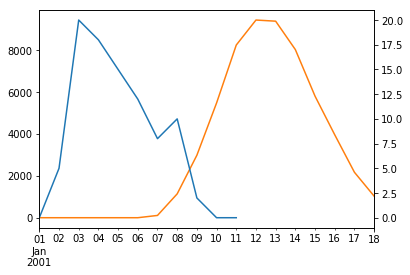

In [115]:
ax = plt.axes()

df = pd.DataFrame({'P': P, 'Q': Q})
df['P'].plot(ax=ax, secondary_y=True, label='rainfall')
df['Q'].plot(ax=ax, label='Discharge')